In [1]:
import json
import os
import swat
import pandas as pd

from pprint import pprint
from string import ascii_uppercase

from graphviz import Digraph

In [2]:
host = os.environ['CAS_HOST_ORGRD']
port = int(os.environ['CAS_PORT'])

In [3]:
colNames = ["from", "to", "weight"]

links = [
    ("A", "B", 1),
    ("A", "E", 1),
    ("B", "C", 1),
    ("C", "A", 6),
    ("C", "D", 1),
    ("D", "E", 3),
    ("D", "F", 1),
    ("E", "B", 1),
    ("E", "C", 4),
    ("F", "E", 1),
    ("E", "A", 1),
]

dfLinkSetIn = pd.DataFrame(links, columns=colNames)

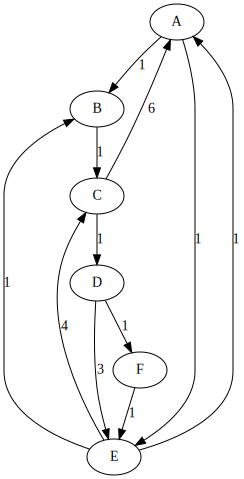

In [4]:
graph = dfLinkSetIn.to_dict(orient='records')
nodes = ['A', 'B', 'C', 'D', 'E', 'F']

dot = Digraph()

for item in nodes:
    dot.node(item)

for pair in graph:
    dot.edge(pair['from'], pair['to'], label=str(pair['weight']))

dot

In [5]:
conn = swat.CAS(host, port)

In [6]:
_ = conn.loadactionset("network")

NOTE: Added action set 'network'.


In [7]:
_ = conn.upload(dfLinkSetIn, casout=dict(name='LinkSetIn'))

NOTE: Cloud Analytic Services made the uploaded file available as table LINKSETIN in caslib CASUSERHDFS(daherr).
NOTE: The table LINKSETIN has been created in caslib CASUSERHDFS(daherr) from binary data uploaded to Cloud Analytic Services.


```
proc network
   direction         = directed
   links             = mycas.LinkSetIn
   outNodes          = mycas.NodeSetIn;
   path
      source         = D
      sink           = A
      maxLinkWeight  = 10
      outPathsLinks  = mycas.PathLinks
      outPathsNodes  = mycas.PathNodes;
run;
```

In [8]:
conn.network.path(links=dict(name='LinkSetIn'), 
                  outnodes=dict(name='NodeSetOut'), 
                  direction='directed', 
                  source='D', 
                  sink='A', 
                  maxlinkweight=10, 
                  outpaths=dict(name='PathLinks'), 
                  outpathsnodes=dict(name='PathNodes'))

NOTE: The number of nodes in the input graph is 6.
NOTE: The number of links in the input graph is 11.
NOTE: Processing path enumeration using 80 threads across 5 machines.
NOTE: Processing path enumeration between 1 source nodes and 1 sink nodes.
NOTE: The algorithm found 3 paths.
NOTE: Processing path enumeration used 0.00 (cpu: 0.00) seconds.


[OutputCasTables]

                 casLib        Name Label  Rows  Columns                                           casTable
 0  CASUSERHDFS(daherr)  NodeSetOut           6        1  CASTable('NodeSetOut', caslib='CASUSERHDFS(dah...
 1  CASUSERHDFS(daherr)   PathLinks          10        7  CASTable('PathLinks', caslib='CASUSERHDFS(dahe...
 2  CASUSERHDFS(daherr)   PathNodes          13        5  CASTable('PathNodes', caslib='CASUSERHDFS(dahe...

[ProblemSummary]

 Problem Summary
 
             Name1           Label1       cValue1  nValue1
 0        numNodes  Number of Nodes             6      6.0
 1        numLinks  Number of Links            11     11.0
 2  graphDirection  Graph Direction      Directed      NaN

[SolutionSummary]

 Solution Summary
 
          Name1           Label1       cValue1   nValue1
 0  problemType     Problem Type          Path       NaN
 1       status  Solution Status            OK       NaN
 2     numPaths  Number of Paths             3  3.000000
 3      cpuTime         CPU Time          0.00  0.000000
 4     realTime        Real Time          0.00  0.001804

[numPaths]

 3

[solutionStatus]

 'OK'

[solutionStatusCode]

 0

+ Elapsed: 0.0635s, user: 0.089s, sys: 0.147s, mem: 401mb

In [9]:
conn.fetch(table=dict(name='PathLinks'))

,source,sink,path,order,from,to,weight
0,D,A,0.0,0.0,D,E,3.0
1,D,A,0.0,1.0,E,A,1.0
2,D,A,1.0,0.0,D,F,1.0
3,D,A,1.0,1.0,F,E,1.0
4,D,A,1.0,2.0,E,A,1.0
5,D,A,2.0,0.0,D,F,1.0
6,D,A,2.0,1.0,F,E,1.0
7,D,A,2.0,2.0,E,B,1.0
8,D,A,2.0,3.0,B,C,1.0
9,D,A,2.0,4.0,C,A,6.0


In [10]:
conn.fetch(table=dict(name='PathNodes'))

,source,sink,path,order,node
0,D,A,0.0,0.0,D
1,D,A,0.0,1.0,E
2,D,A,0.0,2.0,A
3,D,A,1.0,0.0,D
4,D,A,1.0,1.0,F
5,D,A,1.0,2.0,E
6,D,A,1.0,3.0,A
7,D,A,2.0,0.0,D
8,D,A,2.0,1.0,F
9,D,A,2.0,2.0,E


In [11]:
conn.fetch(table=dict(name='NodeSetOut'))

,node
0,A
1,B
2,C
3,D
4,E
5,F


__Note__: take the PathLinks and PathNodes tables, select on Path to get the individual ones, then plot the paths.

In [12]:
dfPathLinks = pd.DataFrame(conn.fetch(table=dict(name='PathLinks'))['Fetch'])

In [14]:
dfSubPath = dfPathLinks[['from', 'to', 'path', 'order']]

In [15]:
dfSubPath

,from,to,path,order
0,D,E,0.0,0.0
1,E,A,0.0,1.0
2,D,F,1.0,0.0
3,F,E,1.0,1.0
4,E,A,1.0,2.0
5,D,F,2.0,0.0
6,F,E,2.0,1.0
7,E,B,2.0,2.0
8,B,C,2.0,3.0
9,C,A,2.0,4.0


In [16]:
dfComplete = pd.merge(dfLinkSetIn, dfSubPath, how='left', left_on=['from', 'to'], right_on=['from', 'to'])

In [17]:
dfComplete

,from,to,weight,path,order
0,A,B,1,NaN,NaN
1,A,E,1,NaN,NaN
2,B,C,1,2.0,3.0
3,C,A,6,2.0,4.0
4,C,D,1,NaN,NaN
5,D,E,3,0.0,0.0
6,D,F,1,1.0,0.0
7,D,F,1,2.0,0.0
8,E,B,1,2.0,2.0
9,E,C,4,NaN,NaN


In [29]:
list_paths = list(dfPathLinks['path'].unique())

aggregate_plots = []

for path in list_paths:
    path_edges = dfComplete.loc[dfComplete['path'] == path][['from', 'to']].to_dict(orient='records')
    path_nodes = list(set([v for row in path_edges for k,v in row.items()]))

    dot2 = Digraph()

    for item in nodes:
        if item in path_nodes:
            dot2.node(item, color='blue', penwidth='2')
        else:
            dot2.node(item)

    path_tuples = [(row['from'], row['to']) for row in path_edges]

    for pair in graph:
        if (pair['from'], pair['to']) in path_tuples:
            dot2.edge(pair['from'], pair['to'], label=str(pair['weight']), color='blue', penwidth='2')
        else:
            dot2.edge(pair['from'], pair['to'], label=str(pair['weight']))

    aggregate_plots.append(dot2)

### Step 7: Clean up everything. 

Make sure we know what tables we created, drop them, and close our connection.
(This is probably overkill, since everything in this session is ephemeral anyway, but good practice nonetheless.

In [ ]:
conn.tableinfo()

In [ ]:
conn.droptable(name='LinkSetIn', quiet=True)
conn.droptable(name='nodeSetOut', quiet=True)
conn.droptable(name='pathLinks', quiet=True)
conn.droptable(name='pathNodes', quiet=True)

In [ ]:
conn.close()